## Chrome Data Analysis ##

The Cambridge Analytica and Facebook incident created a lot of uproar about data privacy and security. Although it is just Facebook that is being targeted on social media, your data is being collected by every entity on the internet that you interact with. And it is usually collected to make your experience better. Who doesn’t like a food recommendation on an app, when you are really hungry. It makes you lazy but also saves you time.

I requested Google to send me ‘my’ data, for which they took around a day. I was shocked at the granularity of the data. It has everything from the URL I visited a year ago (at the leaf ), to my location data whenever I gave any app my location permission (with data about my altitude, velocity, heading, vertical accuracy and what not). Basically they have stored everything that I have ever searched for in a Google App.

I wanted to play around with my browsing data to see if I could get something useful out of it. I used python 3.6 and did all my computation in pandas. Json, datetime, tldextract and regex were the main packages that I imported to clean up the data. I am particularly an admirer of the color palette in seaborn and have used that for my visualizations.

Briefly; I extracted the json file, cleaned it up, extracted domain, subdomain, security etc from URL data and categorized different domains into these 7 categories;

i. Learning — Everything from coursera to stack overflow to piazza

ii. Entertainment — Netflix, Facebook,…

iii. Communication — Whatsapp, Messenger, GroupMe, Gmail,…

iv. Job Search — Yeah had to get that in, since I started spending a lot of time on it

v. General — Everything from a normal google search to booking flights to ordering food

vi. News — Well not a lot since I joined Tech.

vii. Uncategorized — All the other stuff

The above categorization was done based on the extracted domain name.

Background: I have data from March, 2017 to Feb, 2018. I left my job as an Analytics consultant in June 2017 and joined Georgia Tech in Aug 2018. This might help context of the charts below

Since joining Tech, I found a stark increase in my internet usage.



In [1]:
import os
os.chdir('C:\\Users\\Jeh\\Desktop\\Google Data\\takeout-20180329T030349Z-001\\Takeout\\Chrome')

import pandas as pd
import numpy as np
import json

import datetime
import tldextract

Read the data and filter it

In [3]:
with open("BrowserHistory.json", encoding = 'UTF-8') as f:
    data = json.loads(f.read())
    df = pd.DataFrame(data["Browser History"])
# A possible param if differentiation is needed b/w different clients
df.drop('client_id', axis=1, inplace=True)
df.drop('favicon_url', axis=1, inplace=True)
df.sample(1)

,page_transition,time_usec,title,url
86452,LINK,1491998862838628,la quica - Google Search,https://www.google.co.in/search?q=curly+haired...


In [4]:
dfcopy=df.copy()
df= df[(df['page_transition'] == "LINK") | (df['page_transition'] == "TYPED")]

Some datetime operations on the data

In [5]:
df['date_time'] = df['time_usec'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000000))
df['date'] = df['date_time'].apply(lambda x: x.date())
df['day_of_week'] = df['date_time'].apply(lambda x: x.weekday())
df['month'] = df['date_time'].apply(lambda x: x.month)
df['month'] = df['month'].apply(lambda x: '%02d' % x)
df['year'] = df['date_time'].apply(lambda x: x.year)
df['year_month'] = df.apply(lambda x: int(str(x['year'])+x['month']),axis=1)
df['month'] = df['month'].apply(lambda x: int(x))
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if ((x==5) | (x==6)) else 0)
df['hour'] = df['date_time'].apply(lambda x: x.hour)

In [6]:
#Get values for URL security
df['secure'] = df['url'].apply(lambda x: x[0:6])
df['is_secure'] = 0
df['is_secure'] = df['secure'].apply(lambda x: 1 if x !='http:/' else 0)
df['value']=1

In [8]:
#Function to get values domain and sub-domain names
def get_domain(x):
    domain = tldextract.extract(x)[1]
    sub_domain = tldextract.extract(x)[0]
    if sub_domain == "mail":
        return sub_domain + "." + domain
    if domain == "google" and sub_domain=="www":
        return "google_search" 
    return domain

df['domain'] = df['url'].apply(get_domain)

Write data to a csv, categorize domains into **Learning, Entertainment, Communication, News, General, Job Search** and **Uncategorized**

In [9]:
#Read data and merge
dcat = pd.read_csv('domaincategory.csv')
dfcat=df.merge(dcat, on =['domain'], how ='left')

Plots

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='year_month', data=dfcat)

C:\Users\Jeh\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


C:\Users\Jeh\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


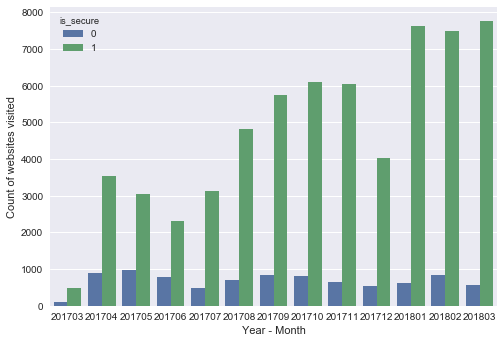

In [18]:
##Browsing pattern (Secure vs Unsecure)
c1 = sns.countplot(x="year_month", hue="is_secure", data=dfcat)
a = c1.set(xlabel='Year - Month', ylabel='Count of websites visited')
plt.show(a)

The number of secure webpages visited have increased, while visits to unsecure webpages have fairly remained constant. You can also see a drop in December. (Winter break!)

The heatmap below can tell you when I started my Master’s program at Tech. There is a sudden increase in ‘Learning’ websites from August 2017, with a slight drop in December. ‘Job Search’ has also become darker in January and February of 2018. ‘Entertainment’ also dropped in the final two months of the Fall semester, so I know what to expect in March and April 2018!

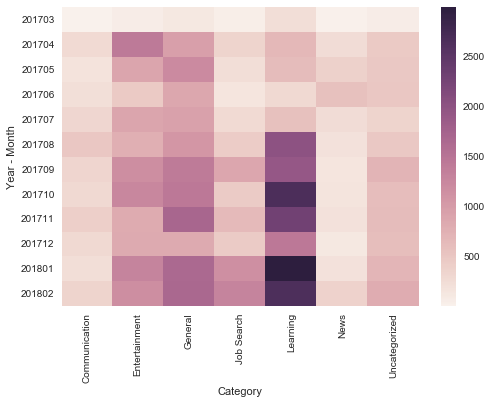

In [22]:
##Heatmap of categories over year_month
df_bycat = pd.DataFrame(dfcat[dfcat['year_month']!=201803].groupby(by = ['year_month', 'category'], as_index=False)['value'].sum())
result = df_bycat.pivot(index='year_month', columns='category', values='value')
a1 = sns.heatmap(result)
a1.set(xlabel='Category', ylabel='Year - Month')
plt.show(a1)

Digging deeper into a week level analysis, I always start the week studying but it drops over time. Can really blame myself here. ‘Entertainment’ on the other hand increases slightly as the week progresses. ‘Job Search’ again drops as the week progresses. Maybe its the guilt on Sunday night that triggers the sudden increase in Learning and Job Search on a Monday.

Note: I limited the data for the below map to dates after I joined GeorgiaTech.

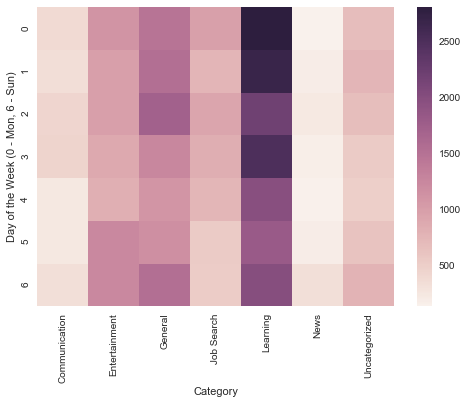

In [25]:
##Heatmap of categories over weekday
df_bycat_weekday = pd.DataFrame(dfcat[(dfcat['year_month']!=201803) & (dfcat['year_month']>=201708)].groupby(by = ['day_of_week', 'category'], as_index=False)['value'].sum())
result = df_bycat_weekday.pivot(index='day_of_week', columns='category', values='value')
a2 = sns.heatmap(result)
a2.set(xlabel='Category', ylabel='Day of the Week (0 - Mon, 6 - Sun)')
plt.show(a2)

Digging deeper into an hour level analysis, you can see that most of the learning begins around 9AM, when classes commence, peaking around 3–4PM. Entertainment also peaks around that time, which can be attributed to european football (soccer) matches. And you can deduce my sleep patterns from the dry areas between 2AM and 8AM.

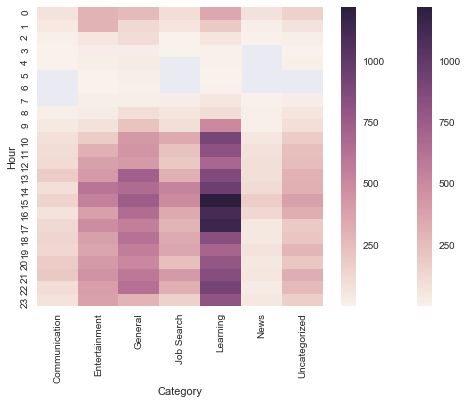

In [27]:
##Heatmap of categories over Hour
df_bycat_hour = pd.DataFrame(dfcat[(dfcat['year_month']!=201803) & (dfcat['year_month']>201708)].groupby(by = ['hour', 'category'], as_index=False)['value'].sum())
result = df_bycat_hour.pivot(index='hour', columns='category', values='value')
a3 = sns.heatmap(result)
a3.set(xlabel='Category', ylabel='Hour')
plt.show(a3)

Another interesting analysis is at a day-hour level. There is a peculiar drop around 4–6PM on sunday (Day 6). That is due to the routine grocery visits to Target/Publix. As expected Fridays (Day 4) end earlier than the rest and Saturdays begin later than the others.

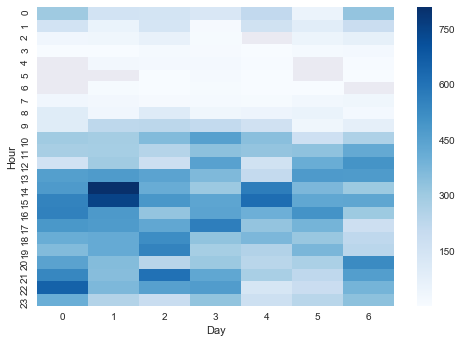

In [30]:
##Heatmap of browsing pattern over Hour by day of the week
df_byday_hour = pd.DataFrame(dfcat[(dfcat['year_month']!=201803) & (dfcat['year_month']>201708)].groupby(by = ['hour', 'day_of_week'], as_index=False)['value'].sum())
result = df_byday_hour.pivot(index='hour', columns='day_of_week', values='value')
a5 = sns.heatmap(result,cmap="Blues")
a5.set(xlabel='Day', ylabel='Hour')
plt.show(a5)

This final visualization is just see how effective I am while working in these separate categories.

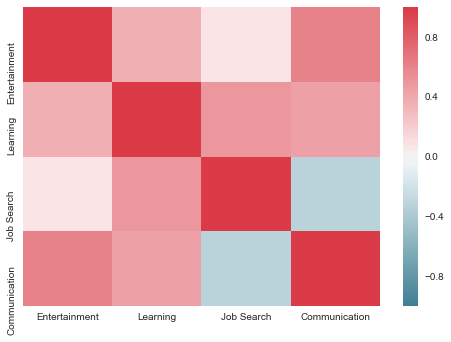

In [31]:
dffinal = dfcat.groupby(by=['date','hour','category'], as_index=False)['value'].sum()
dffinal.to_csv('df.csv')

##Calculate correlation matrix
catbyhour = pd.read_csv('category_by_hour.csv')
catbyhour[['Entertainment', 'Learning', 'Job Search', 'Communication']].corr()

##Correlation matrix between the 4 categories
a6 = sns.heatmap(catbyhour[['Entertainment', 'Learning', 'Job Search', 'Communication']].corr(),cmap = sns.diverging_palette(220, 10, as_cmap=True))
plt.show(a6)

Clearly, while searching for jobs, my communication goes down. The correlation between Job Search and Entertainment is low (or not too high) too, which is good. Learning and Entertainment and not too highly correlated, while Communication increases when Entertainment is on.